# Isolated Sign Language Recognition with GRU

## 1. Import Libraries and define functions

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import time

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def draw_landmarks(image, results):
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connection

In [ ]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [ ]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

## 2. Create Video Dataset

In [ ]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data4')

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Jumlah video
no_sequences = 25

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [ ]:
DATA_PATH = 'C:/Users/Toby/Documents/kuliah/Skripsi'
path = os.path.join(DATA_PATH, 'MP_Data4')
os.mkdir(path)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:/Users/Toby/Documents/kuliah/Skripsi\\MP_Data4'

In [ ]:
path = os.path.join(DATA_PATH, 'MP_Data4')
for action in actions:
    try:
        path1 = os.path.join(path, str(action))
        os.mkdir(path1)
    except:
        print(f'error untuk {action}')
        pass


error untuk hello
error untuk thanks
error untuk iloveyou


In [ ]:
#Pilih Device webcam dan kemudian set capture size
cap = cv2.VideoCapture(1)
cap.set(3, 640)
cap.set(4, 480)

#Bikin list untuk hitung lama video di proses
time_list = []


fourcc = cv2.VideoWriter_fourcc(*'H264')
# Loop through actions
for action in actions:
    # Loop through sequences aka videos
    for sequence in range(no_sequences):
        fps = 30
        video_size = (640, 480)
        file_path = os.path.join(path, action, f'video {action} {sequence}.mp4')
        out = cv2.VideoWriter(file_path, fourcc, fps, video_size)
        start_time = time.time()

        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):

            # Read feed
            ret, frame = cap.read()

            out.write(frame)

            # NEW Apply wait logic
            if frame_num == 0:
                cv2.putText(frame, 'STARTING COLLECTION', (120,200),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                cv2.putText(frame, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                # Show to screen
                cv2.imshow('OpenCV Feed', frame)
                cv2.waitKey(500)
            else:
                cv2.putText(frame, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                # Show to screen
                cv2.imshow('OpenCV Feed', frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        end_time = time.time()
        processing_time = end_time-start_time-0.5
        time_list.append(f"aksi : {action} , video {sequence}: Processing time {processing_time:.2f} seconds")
        print(f"aksi : {action} , video {sequence}: Processing time {processing_time:.2f} seconds")
        out.release()

cap.release()
cv2.destroyAllWindows()

aksi : hello , video 0: Processing time 2.99 seconds
aksi : hello , video 1: Processing time 0.97 seconds
aksi : hello , video 2: Processing time 0.96 seconds
aksi : hello , video 3: Processing time 0.93 seconds
aksi : hello , video 4: Processing time 0.95 seconds
aksi : hello , video 5: Processing time 0.92 seconds
aksi : hello , video 6: Processing time 0.96 seconds
aksi : hello , video 7: Processing time 0.97 seconds
aksi : hello , video 8: Processing time 0.96 seconds
aksi : hello , video 9: Processing time 0.93 seconds
aksi : hello , video 10: Processing time 0.94 seconds
aksi : hello , video 11: Processing time 0.87 seconds
aksi : hello , video 12: Processing time 0.94 seconds
aksi : hello , video 13: Processing time 0.94 seconds
aksi : hello , video 14: Processing time 0.93 seconds
aksi : hello , video 15: Processing time 0.93 seconds
aksi : hello , video 16: Processing time 0.93 seconds
aksi : hello , video 17: Processing time 0.94 seconds
aksi : hello , video 18: Processing ti

In [ ]:
cap.release()
cv2.destroyAllWindows()

## 3. Extract landmarks with MediaPipe Holistic from video

In [ ]:
def extract_to_row(results):
    pose_features = ['x','y','z','visibility']
    hand_features = ['x','y','z']
    features= []
    values = []
    if hasattr(results.pose_landmarks, 'landmark'):
        for i,value in enumerate(results.pose_landmarks.landmark):
            features.extend([f'pose_x{i}', f'pose_y{i}',f'pose_z{i}',f'pose_vis{i}'])
            values.extend([value.x,value.y,value.z,value.visibility])
    else:
        for i in range(0,33):
            features.extend([f'pose_x{i}', f'pose_y{i}',f'pose_z{i}',f'pose_vis{i}'])
            values.extend([0,0,0,0])

    if hasattr(results.left_hand_landmarks, 'landmark'):
        for i,value in enumerate(results.left_hand_landmarks.landmark):
            features.extend([f'Lhand_x{i}', f'Lhand_y{i}',f'Lhand_z{i}'])
            values.extend([value.x,value.y,value.z])
    else:
        for i in range(0,21):
            features.extend([f'Lhand_x{i}', f'Lhand_y{i}',f'Lhand_z{i}'])
            values.extend([0,0,0])


    if hasattr(results.right_hand_landmarks, 'landmark'):
        for i,value in enumerate(results.right_hand_landmarks.landmark):
            features.extend([f'Rhand_x{i}', f'Rhand_y{i}',f'Rhand_z{i}'])
            values.extend([value.x,value.y,value.z])
    else:
        for i in range(0,21):
            features.extend([f'Rhand_x{i}', f'Rhand_y{i}',f'Rhand_z{i}'])
            values.extend([0,0,0])

    data = {feature:values[i] for i,feature in enumerate(features)}
    return data



In [ ]:
import warnings
warnings.filterwarnings('ignore')

DATA_PATH = 'C:/Users/Toby/Documents/kuliah/Skripsi'
path = os.path.join(DATA_PATH, 'MP_Data4')

fourcc = cv2.VideoWriter_fourcc(*'H264')
dataframes = []
video_titles = []
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(no_sequences):
            video_file = os.path.join(path,action, f'video {action} {sequence}.mp4')
            cap = cv2.VideoCapture(video_file)
            fps = 30
            video_size = (640, 480)
            file_path = os.path.join(path, action, f'video {action} {sequence} landmarked.mp4')
            out = cv2.VideoWriter(file_path, fourcc, fps, video_size)
            video_df = pd.DataFrame()
            for frame_num in range(sequence_length):
                # Read feed
                ret, frame = cap.read()
                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_landmarks(image, results)

                out.write(image)
                #cv2.imshow('OpenCV Feed', image)

                # NEW Export keypoints
                frame_data = extract_to_row(results)
                video_df = video_df.append([frame_data])
                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
            out.release()
            dataframes.append(video_df.reset_index(drop=True))
            video_titles.append(f'{action}_{sequence}')

    cap.release()
    cv2.destroyAllWindows()

result_df = pd.concat(dataframes,keys=video_titles)

In [ ]:
df_copy = result_df.copy()
df_copy = df_copy.reset_index()
df_copy.to_csv('dataolah.csv', encoding='utf-8-sig',sep='\t')
df_copy

,level_0,level_1,pose_x0,pose_y0,pose_z0,pose_vis0,pose_x1,pose_y1,pose_z1,pose_vis1,...,Rhand_z17,Rhand_x18,Rhand_y18,Rhand_z18,Rhand_x19,Rhand_y19,Rhand_z19,Rhand_x20,Rhand_y20,Rhand_z20
0,hello_0,0,0.501052,0.420169,-0.712623,0.999916,0.533753,0.362733,-0.661104,0.999805,...,0.004770,0.264227,0.335866,0.003623,0.282475,0.327549,0.007007,0.297263,0.327530,0.009893
1,hello_0,1,0.501066,0.422809,-0.728364,0.999919,0.533666,0.363798,-0.685645,0.999808,...,-0.036860,0.204077,0.487396,-0.057683,0.224089,0.505290,-0.062770,0.237835,0.533397,-0.062220
2,hello_0,2,0.501294,0.423872,-0.713810,0.999924,0.533650,0.364250,-0.671955,0.999818,...,-0.030658,0.207007,0.492410,-0.051859,0.226314,0.513592,-0.054240,0.239460,0.540915,-0.050289
3,hello_0,3,0.501525,0.424209,-0.712394,0.999928,0.533642,0.364346,-0.670316,0.999824,...,-0.030647,0.207112,0.491271,-0.051757,0.226279,0.513971,-0.053678,0.238743,0.542686,-0.049404
4,hello_0,4,0.501666,0.424366,-0.707118,0.999931,0.533649,0.364371,-0.664124,0.999831,...,-0.030727,0.207370,0.493229,-0.051905,0.226390,0.515438,-0.053923,0.239211,0.543826,-0.049581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,iloveyou_24,25,0.482125,0.448265,-0.684487,0.999800,0.503916,0.392895,-0.651611,0.999559,...,-0.012645,0.290051,0.586026,-0.025537,0.296172,0.558159,-0.025089,0.304245,0.532749,-0.020339
2246,iloveyou_24,26,0.482244,0.448325,-0.672828,0.999789,0.504110,0.392880,-0.640097,0.999538,...,-0.012304,0.289809,0.585582,-0.025345,0.295928,0.557821,-0.024768,0.304018,0.532468,-0.019819
2247,iloveyou_24,27,0.482438,0.448528,-0.650273,0.999782,0.504379,0.392907,-0.617301,0.999523,...,-0.012127,0.289798,0.585375,-0.025155,0.295871,0.557557,-0.024591,0.303956,0.532163,-0.019678
2248,iloveyou_24,28,0.484730,0.451506,-0.693505,0.999759,0.506482,0.394640,-0.658996,0.999462,...,-0.012261,0.295441,0.577266,-0.024803,0.301520,0.548118,-0.024383,0.309361,0.521698,-0.019788


## 4. Create labels and split data into training and testing

In [ ]:
df = pd.read_csv('dataolah.csv', delimiter='\t', encoding='utf-8')
label_map = {label:num for num, label in enumerate(actions)}
df = df.iloc[:, 1:]

In [ ]:
temp_df = df.copy()
temp_df = temp_df.drop(temp_df.columns[[0,1]],axis=1)
reshaped_data = temp_df.values.reshape(len(actions)*(no_sequences),30,258)


# Create label data
labels = []
for i in range(0,len(actions)):
    for j in range(0,no_sequences):
        labels.append(i)
labels =np.array(labels)
labels.shape
labels


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
X = np.array(reshaped_data)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape , y_train.shape

((60, 30, 258), (60, 3))

In [ ]:
X_test.shape , y_test.shape

((15, 30, 258), (15, 3))

5. Simple model with GRU

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
model = Sequential()
model.add(GRU(64, return_sequences=False, activation='relu', input_shape=(30,258)))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax')) #Linear -> Softmax
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 64)                62208     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 3)                 99        
                                                                 
Total params: 64387 (251.51 KB)
Trainable params: 64387 (251.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train,batch_size=4, epochs=1000, callbacks=[tb_callback])

## 5. Predictions

In [ ]:
yhat = model.predict(X_test)
yhat  #Prediction output

1/1 [==============================] - 1s 552ms/step


array([[1.3196183e-10, 1.2764864e-09, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 1.5188481e-25],
       [9.9999928e-01, 2.3247316e-07, 4.4184830e-07],
       [1.0000000e+00, 7.3945135e-11, 1.2680925e-09],
       [5.0716176e-10, 3.2350884e-09, 1.0000000e+00],
       [2.9845582e-09, 4.7673279e-09, 1.0000000e+00],
       [1.8146172e-38, 1.0000000e+00, 7.7587640e-25],
       [5.9628996e-11, 1.2228294e-09, 1.0000000e+00],
       [2.8348712e-14, 2.9934419e-08, 1.0000000e+00],
       [9.9999917e-01, 1.9360009e-08, 7.9957198e-07],
       [2.5759247e-05, 7.1943896e-07, 9.9997354e-01],
       [1.0000000e+00, 2.5139233e-11, 3.7200392e-11],
       [1.0000000e+00, 4.3279984e-11, 1.8642117e-09],
       [5.7620391e-11, 1.0981377e-09, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 9.8890552e-28]], dtype=float32)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
accuracy_score(ytrue, yhat)

0.9333333333333333

In [ ]:
ytrue

[2, 1, 0, 0, 2, 2, 1, 2, 2, 0, 0, 0, 0, 2, 1]

In [ ]:
yhat

[2, 1, 0, 0, 2, 2, 1, 2, 2, 0, 2, 0, 0, 2, 1]

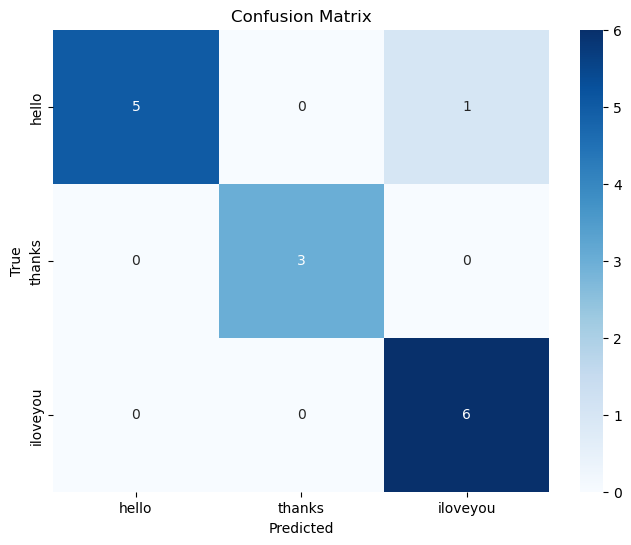

In [ ]:
conf_matrix = confusion_matrix(ytrue, yhat)
class_labels = ['hello', 'thanks', 'iloveyou']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
class_report = classification_report(ytrue, yhat)
print(class_report)

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       1.00      1.00      1.00         3
           2       0.86      1.00      0.92         6

    accuracy                           0.93        15
   macro avg       0.95      0.94      0.94        15
weighted avg       0.94      0.93      0.93        15

